In [3]:
import pandas as pd
import numpy as np
# import ydata_profiling
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import os
from math import pi
from matplotlib.path import Path
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D
import json

import warnings
warnings.filterwarnings('ignore')

## 공통 전처리

In [4]:
%%time
dtype = {
    'userID': 'int16',
    'answerCode': 'int8',
    'KnowledgeTag': 'int16'
}   

# data set load
DATA_PATH = '/opt/ml/input/data'
train_path = os.path.join(DATA_PATH, 'train_data.csv')
test_path = os.path.join(DATA_PATH, 'test_data.csv')

train_df = pd.read_csv(train_path, dtype=dtype, parse_dates=['Timestamp'])
test_df = pd.read_csv(test_path, dtype=dtype, parse_dates=['Timestamp'])

diff_train = train_df.loc[:, ['userID', 'Timestamp']].groupby('userID').diff().shift(-1)

# total_seconds(): 모든 속성을 초단위로 모아서 변환
diff_train = diff_train['Timestamp'].apply(lambda x: x.total_seconds())

train_df['elapsed'] = diff_train



test_df = pd.read_csv('/opt/ml/input/data/test_data.csv', dtype=dtype, parse_dates=['Timestamp'])


diff_test = test_df.loc[:, ['userID', 'Timestamp']].groupby('userID').diff().shift(-1)

# total_seconds(): 모든 속성을 초단위로 모아서 변환
diff_test = diff_test['Timestamp'].apply(lambda x: x.total_seconds())

test_df['elapsed'] = diff_test
test_df = test_df[test_df['answerCode'] != -1]
test_df = test_df.sort_values(by=['userID', 'Timestamp']).reset_index(drop=True)


df = pd.concat([train_df, test_df])
# df = df.drop(df[df['answerCode']== -1].index) # answerCode = -1 는 예측해야하는 값이므로 제외'Affine

import pytz
kst = pytz.timezone('Asia/Seoul')
df['Timestamp'] = df['Timestamp'].dt.tz_localize('UTC').dt.tz_convert(kst)

CPU times: user 9.8 s, sys: 716 ms, total: 10.5 s
Wall time: 10.5 s


In [5]:
df

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,elapsed
0,0,A060001001,A060000001,1,2020-03-24 09:17:11+09:00,7224,3.0
1,0,A060001002,A060000001,1,2020-03-24 09:17:14+09:00,7225,8.0
2,0,A060001003,A060000001,1,2020-03-24 09:17:22+09:00,7225,7.0
3,0,A060001004,A060000001,1,2020-03-24 09:17:29+09:00,7225,7.0
4,0,A060001005,A060000001,1,2020-03-24 09:17:36+09:00,7225,11.0
...,...,...,...,...,...,...,...
259365,7439,A040197006,A040000197,1,2020-08-21 16:39:45+09:00,2132,4721258.0
259366,7439,A040130001,A040000130,0,2020-10-15 08:07:23+09:00,8832,18.0
259367,7439,A040130002,A040000130,1,2020-10-15 08:07:41+09:00,8832,21.0
259368,7439,A040130003,A040000130,1,2020-10-15 08:08:02+09:00,8244,89.0


## Overview

+ `userID` 사용자의 고유 번호입니다. 총 7,442명의 학생이 있습니다.   
+ `assessmentItemID` 사용자가 푼 문항의 일련 번호입니다.   
+ `testId` 사용자가 푼 문항이 포함된 시험지의 일련 번호입니다.   
+ `answerCode` 사용자가 푼 문항의 정답 여부를 담고 있는 이진 (0/1) 데이터입니다.   
+ `Timestamp` 사용자가 문항을 푼 시간 정보입니다.   
+ `KnowledgeTag` 사용자가 푼 문항의 고유 태그가 담겨져 있습니다.

In [6]:
print(f"""--- BASIC INFORMATIONS ---
userID           : {df.userID.nunique()}
assessmentItemID : {df.assessmentItemID.nunique()}
testID           : {df.testId.nunique()}
mean answer rate : {df.answerCode.sum() / df.shape[0] * 100:.2f}%
KnowledgeTag     : {df.KnowledgeTag.nunique()}
{'-'*26}""")

--- BASIC INFORMATIONS ---
userID           : 7442
assessmentItemID : 9454
testID           : 1537
mean answer rate : 65.46%
KnowledgeTag     : 912
--------------------------


0과 1의 데이터 분포 파악

Text(0.5, 1.0, 'Distribution of answerCode=0')

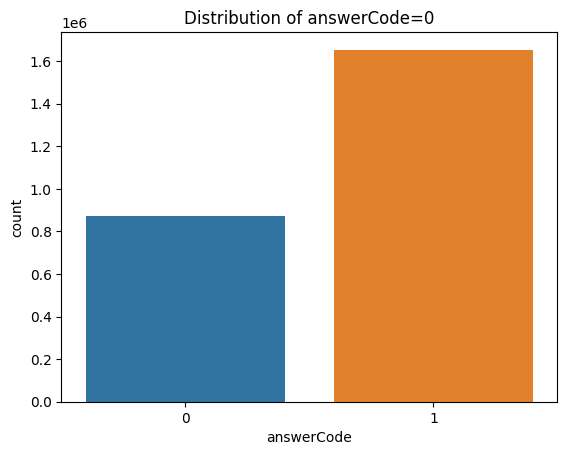

In [7]:
df.answerCode.value_counts()
sns.countplot(data=df, x='answerCode').set_title('Distribution of answerCode=0')

## 이상치 파악

## assessmentitem Id / test Id [희원, 찬웅]

### 문제번호에 따른 정답

### testcode

## timestamp [현정, 희만, … ]

월별 평균, 총합, 개수

In [8]:
last_1M = df.groupby([pd.Grouper(freq='1M',key='Timestamp')])["answerCode"].agg(["mean", "sum", "count"])
last_1M

,mean,sum,count
Timestamp,,,
2020-01-31 00:00:00+09:00,0.706736,29449,41669
2020-02-29 00:00:00+09:00,0.686150,60268,87835
2020-03-31 00:00:00+09:00,0.682923,132371,193830
2020-04-30 00:00:00+09:00,0.649782,128931,198422
2020-05-31 00:00:00+09:00,0.643328,131522,204440
2020-06-30 00:00:00+09:00,0.652473,165259,253281
2020-07-31 00:00:00+09:00,0.666436,201425,302242
2020-08-31 00:00:00+09:00,0.657312,231763,352592
2020-09-30 00:00:00+09:00,0.670203,253542,378306


월별로 뽑아낸 데이터의 개수와 정답률

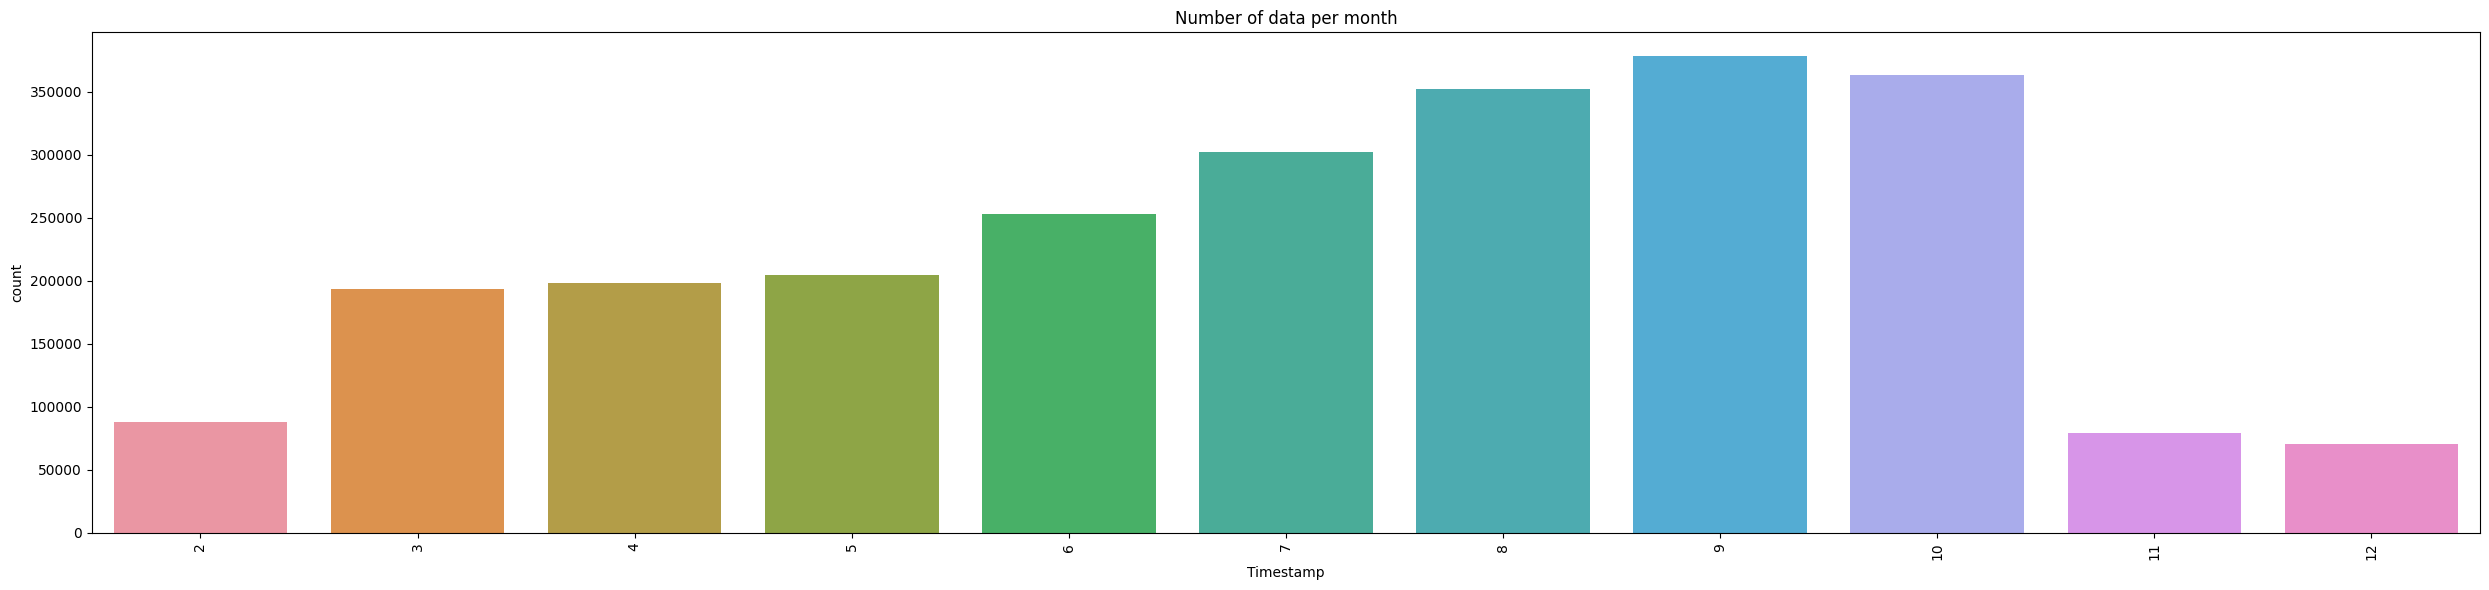

In [9]:
plt.figure(figsize=(25,6))
sns.barplot(x=last_1M[1:].index.month , y=last_1M[1:]['count'])
plt.xticks(rotation=90)
plt.title('Number of data per month')
plt.tight_layout()

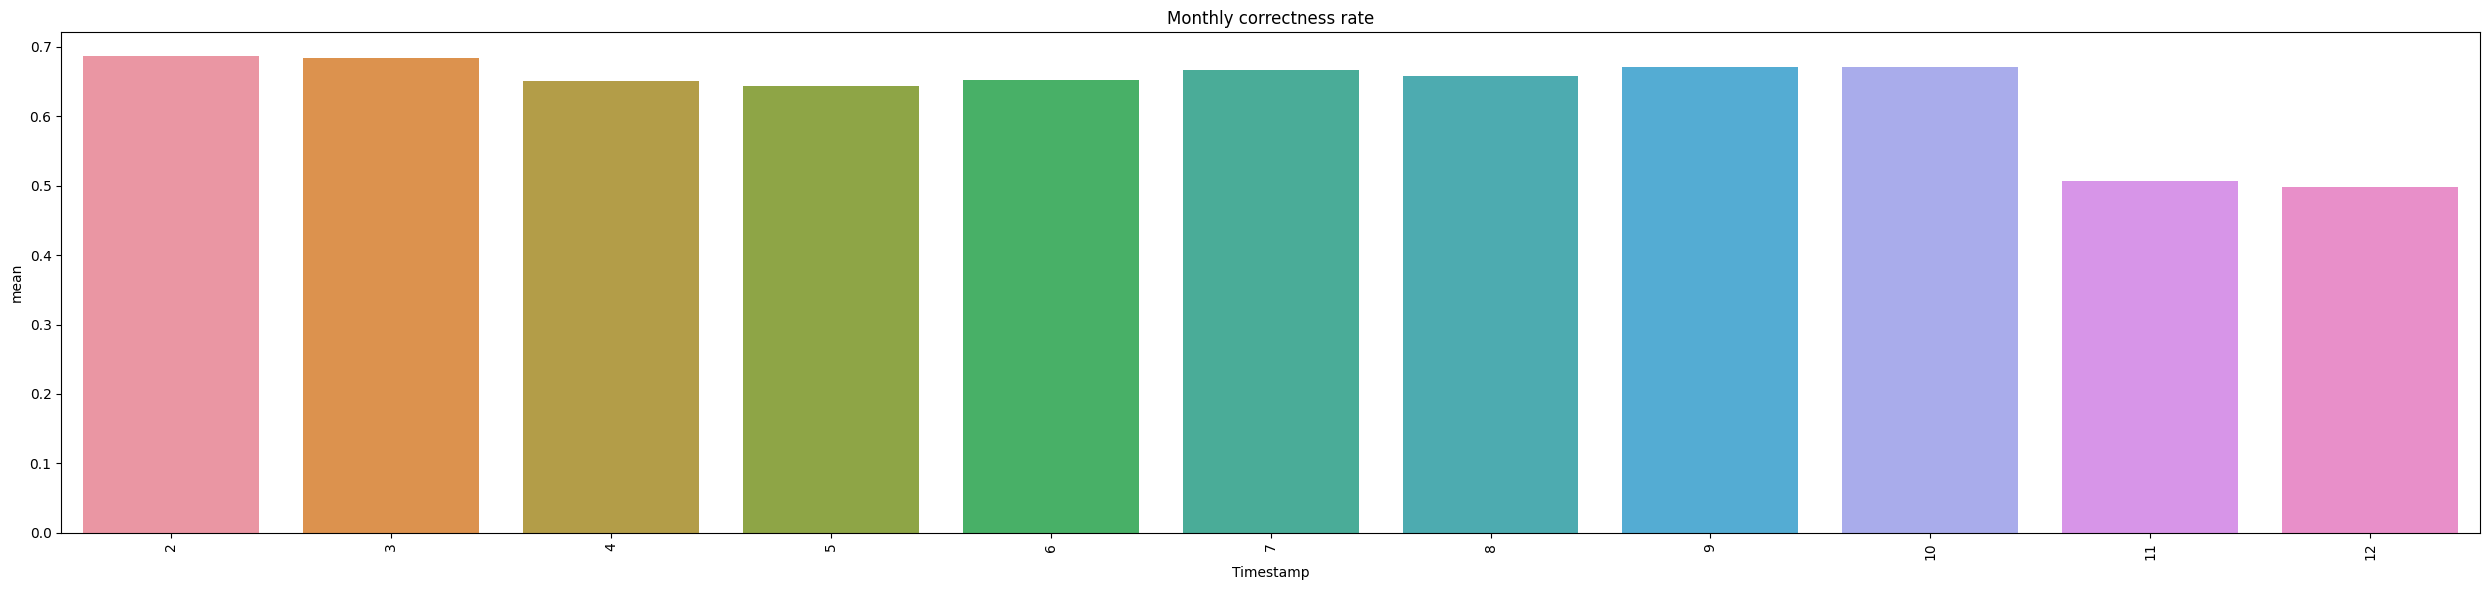

In [10]:
plt.figure(figsize=(25,6))
sns.barplot(x=last_1M[1:].index.month, y=last_1M[1:]['mean'])
plt.xticks(rotation=90)
plt.title('Monthly correctness rate')
plt.tight_layout()

시간대별로 추출

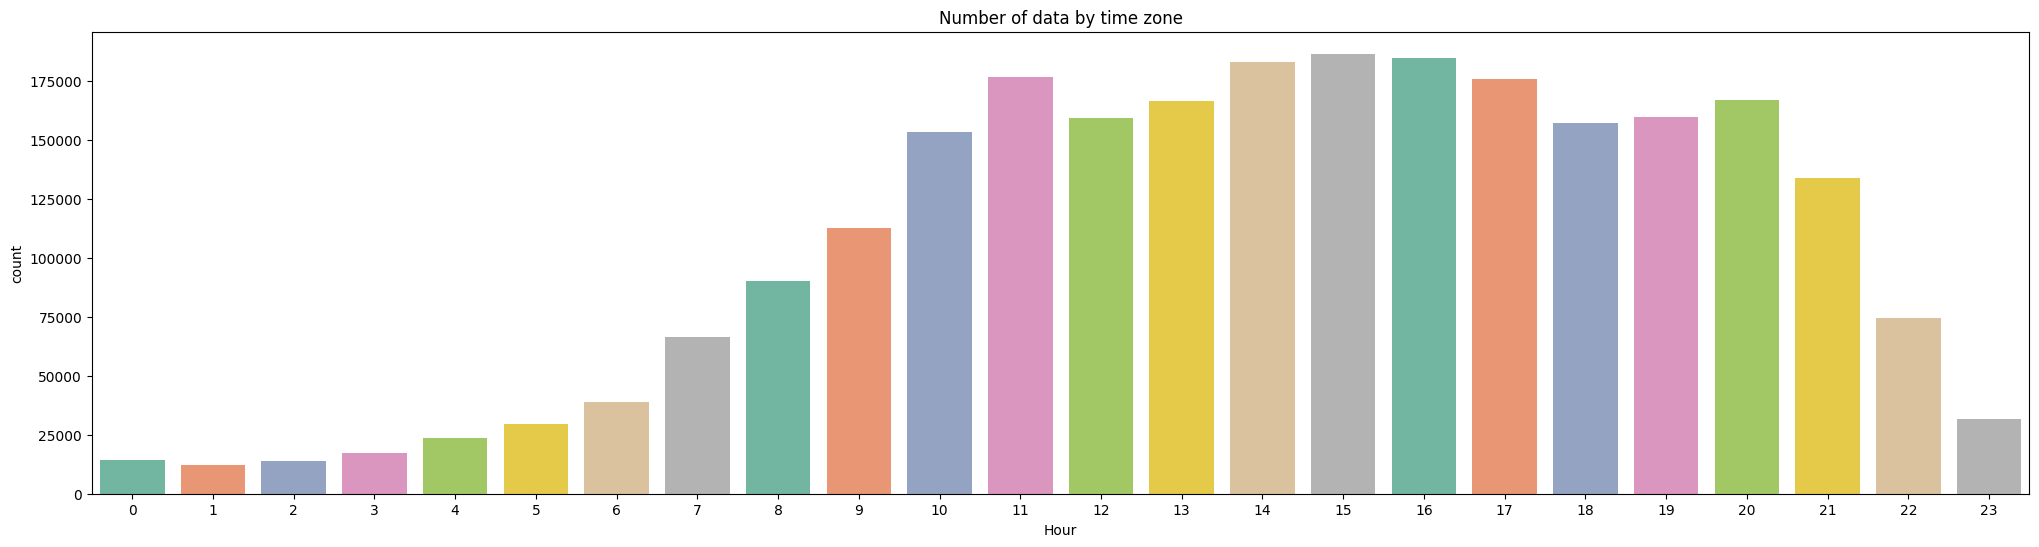

In [11]:
df['Hour'] = df['Timestamp'].dt.hour 
Hour_ans_rate = df.groupby(["Hour"])["answerCode"].agg(["mean", "count"]).reset_index()

plt.figure(figsize=(25,6))
sns.barplot(x="Hour", y="count", data=Hour_ans_rate, palette='Set2')
plt.title('Number of data by time zone')
plt.show()

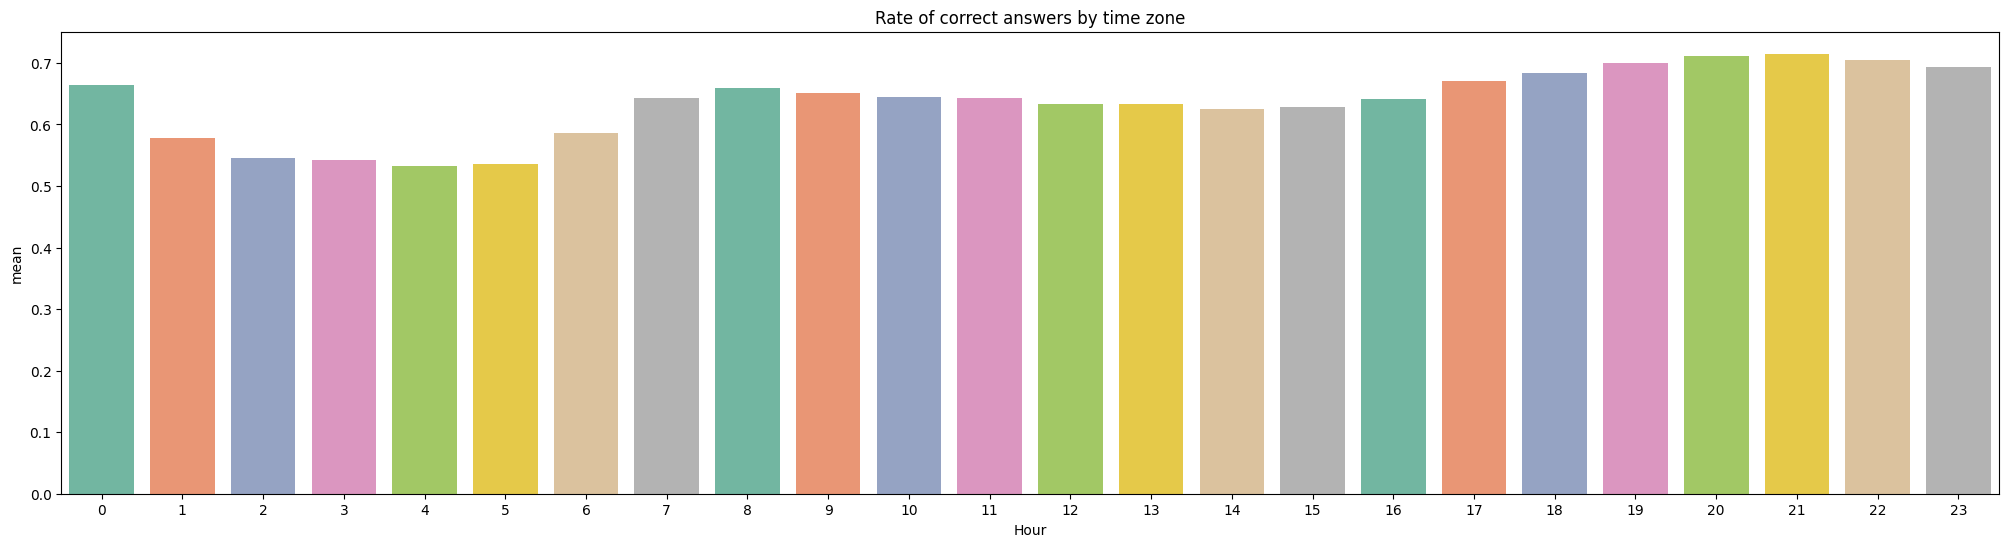

In [12]:
plt.figure(figsize=(25,6))
sns.barplot(x="Hour", y="mean", data=Hour_ans_rate, palette='Set2')
plt.title('Rate of correct answers by time zone')
plt.show()

시간대별 정답률 확인

In [13]:
bins = [0, 6, 12, 18, 24]
labels = ['0~5', '6~11', '12~17', '18~23']
df['hour_range'] = pd.cut(df['Hour'], bins=bins, labels=labels, include_lowest=True)

Hour_range_ans_rate = df.groupby(["hour_range"])["answerCode"].agg(["mean", "count"]).reset_index()

새벽시간에 더 적은 문제를 풀었음에도 평균이 상대적으로 낮은것을 확인가능

In [14]:
Hour_range_ans_rate

,hour_range,mean,count
0,0~5,0.565643,149423
1,6~11,0.644490,757332
2,12~17,0.646343,1053100
3,18~23,0.707137,566101


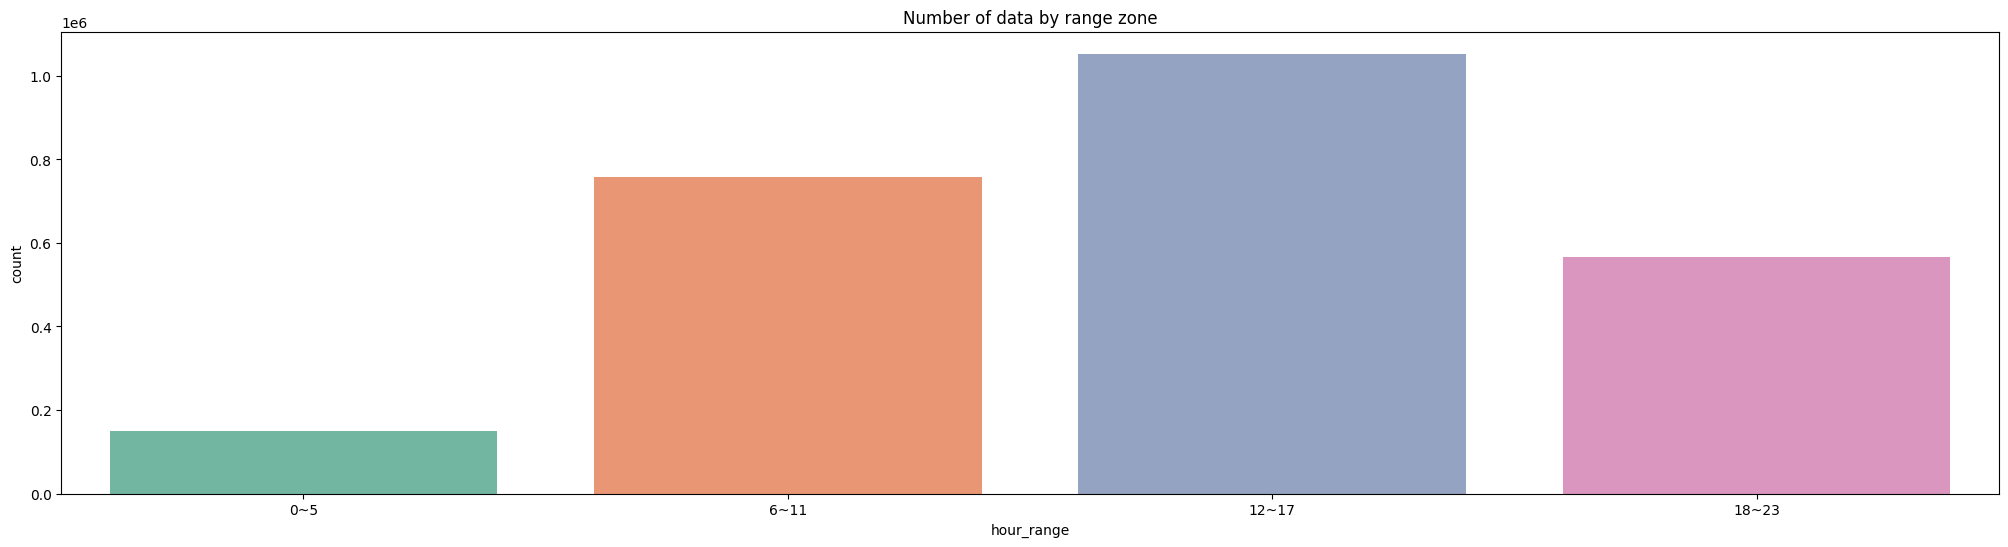

In [15]:
plt.figure(figsize=(25,6))
sns.barplot(x="hour_range", y="count", data=Hour_range_ans_rate, palette='Set2')
plt.title('Number of data by range zone')
plt.show()

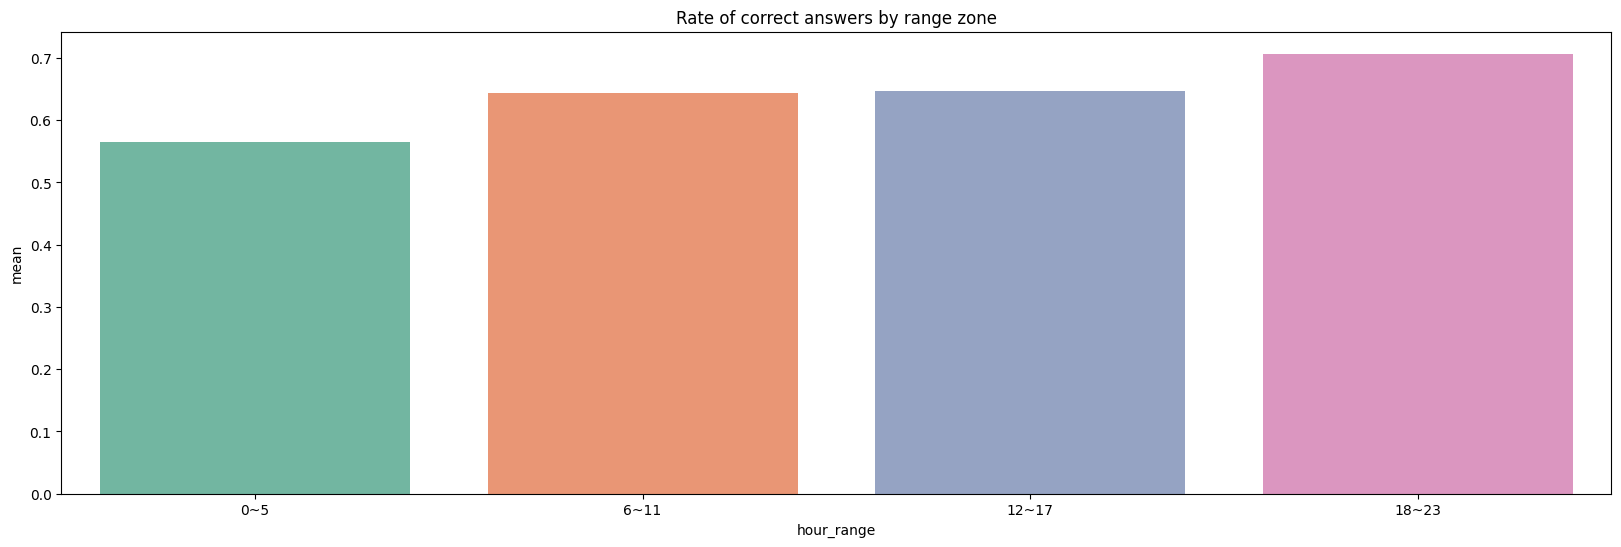

In [16]:
plt.figure(figsize=(20,6))
sns.barplot(x="hour_range", y="mean", data=Hour_range_ans_rate, palette='Set2')
plt.title('Rate of correct answers by range zone')
plt.show()

## knowledgetag

### baseline에서더 많이 노출된 태그가 정답률이 더 높은가?

## testcode + knowledgetag

## 기타